In [1]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
import pandas as pd
import sys
import calendar
import os
from matplotlib.lines import Line2D
import matplotlib.dates as mdates


from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import ConnectionPatch

'''
src_path = sys.path[0].replace("figures\visualization\script", "src")
#replace notebook as scripts
data_path = sys.path[0].replace("figures\visualization\script", "data")
if src_path not in sys.path:
    sys.path.append(src_path)

out_path = sys.path[0].replace("figures\visualization\script", "output")
'''

# set default params of plot
rc_={
    "figure.dpi":300,
    "font.size":10,
    "axes.facecolor":"white",
    "savefig.facecolor":"white",
    "text.usetex":True,
}


In [2]:
def get_merged_df(file_folder=None,log_fn=None,id_exe_unne=None, id_sol_nece=None, id_mini=None):
    log_df=pd.read_excel(log_fn,sheet_name="Sheet1")
    fn_by_exe=log_df[log_df.id==id_exe_unne]["save_fn"].values[0]
    fn_by_sol=log_df[log_df.id==id_sol_nece]["save_fn"].values[0]
    fn_mini=log_df[log_df.id==id_mini]["save_fn"].values[0]
    fn_by_exe=os.path.join(file_folder,fn_by_exe)
    fn_by_sol=os.path.join(file_folder,fn_by_sol)
    fn_mini=os.path.join(file_folder,fn_mini)
    df_by_exe=pd.read_excel(fn_by_exe, sheet_name="op_log",index_col=0)["latest_p_grid_max"].interpolate()
    df_by_sol=pd.read_excel(fn_by_sol, sheet_name="op_log",index_col=0)["latest_p_grid_max"].interpolate()
    df_mini=pd.read_excel(fn_mini, sheet_name="op_log",index_col=0)["latest_p_grid_max"].interpolate()
    df_error=pd.read_excel(fn_by_exe, sheet_name="op_log",index_col=0)["load_bld_error"].interpolate()
    
    # Merge the Series into a DataFrame
    df_merged = pd.merge(df_by_exe, df_by_sol, left_index=True, right_index=True)
    df_merged = pd.merge(df_merged, df_mini, left_index=True, right_index=True)
    df_merged = pd.merge(df_merged, df_error, left_index=True, right_index=True)

    # Rename the columns
    df_merged.columns = ['actual_p_max', 'necessary', 'minimized', 'load_pred_error']
    df_merged['unnecessary']=df_merged["necessary"]-df_merged["actual_p_max"]
    df_merged['unnecessary_minimized']=df_merged["necessary"]-df_merged["minimized"]
    return df_merged

def plot_track_p_max(df_merged,figsize,line_keys=['actual_p_max','necessary','unnecessary'],
                     plot_error_bar=False, ylimit_main=[-150,250],ylimit_sub=[-150,250],fontsize=12,
                     inside_start_day=5,inside_days=1,legend_loc="lower right",
                     save_fn=None):
        line_clr_dic={
                'actual_p_max':'teal',
                'necessary':'green',
                'unnecessary':'coral',
                'unnecessary_minimized':'orange'
        }
        
        fig, ax = plt.subplots(figsize=figsize,dpi=300)

        def plot_ax_data(ax):
                for key in line_keys:
                        ax.plot(df_merged.index, df_merged[key],label=key,color=line_clr_dic[key])
                if plot_error_bar:
                        ax.bar(df_merged.index, df_merged["load_pred_error"])
                ax.yaxis.set_major_formatter(lambda x, pos: f'{abs(x):g}')
                ax.margins(x=0.01)
                ax.hlines(y=0,xmin=df_merged.index[0],xmax=df_merged.index[-1],linestyles='--',colors='gray')
                ax.tick_params(axis='both', direction='in',pad=10)

        plot_ax_data(ax=ax)

        ax.set_ylim(ylimit_main)
        ax.set_xlabel("One month",fontsize=fontsize*1.1)
        ax.set_ylabel("P_grid (kW)",fontsize=fontsize*1.1)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=24*7))
        ax.xaxis.set_minor_locator(mdates.HourLocator(interval=24))
        ax.tick_params(axis='x', rotation=0)

        ax.set_xticklabels(ax.get_xticklabels(),rotation=0,fontsize=fontsize*0.9)
        ax.legend(frameon=False,loc=legend_loc)
        # set the subplot:
        axins = inset_axes(ax, width="60%", height="100%", loc='lower left',
                        bbox_to_anchor=(1.08, -0.015, 1, 1), 
                        bbox_transform=ax.transAxes)

        # plot original data
        plot_ax_data(ax=axins)

        # set x range
        xlim0 = df_merged.index[inside_start_day*96]
        xlim1 = df_merged.index[inside_start_day*96+inside_days*96]

        # set y range
        axins.set_xlim(xlim0, xlim1)
        axins.set_ylim(ylimit_sub)
        axins.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%H'))
        axins.xaxis.set_major_locator(mdates.HourLocator(interval=24))
        axins.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
        axins.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
        #axins.set_xticklabels(axins.get_xticklabels(),rotation=0)
        axins.set_xlabel("One day",fontsize=fontsize*1.1)

        # draw frame in the ori plot
        tx0 = xlim0
        tx1 = xlim1
        ty0 = ylimit_sub[0]
        ty1 = ylimit_sub[1]
        sx = [tx0,tx1,tx1,tx0,tx0]
        sy = [ty0,ty0,ty1,ty1,ty0]
        ax.plot(sx,sy,"black",linewidth=0.8)

        # draw connect lines
        xy = (xlim1,ty1)
        xy2 = (xlim0,ty1)
        con = ConnectionPatch(xyA=xy2,xyB=xy,coordsA="data",coordsB="data",
                axesA=axins,axesB=ax,linestyle="--",linewidth=0.5)
        axins.add_artist(con)

        xy = (xlim1,ty0)
        xy2 = (xlim0,ty0)
        con = ConnectionPatch(xyA=xy2,xyB=xy,coordsA="data",coordsB="data",
                axesA=axins,axesB=ax,linestyle="--",linewidth=0.5)
        axins.add_artist(con)

        # adjust layout and save fig
        plt.tight_layout()
        plt.savefig(save_fn,bbox_inches='tight')
        plt.show()
        

In [3]:
merged_df_Jan=get_merged_df(
    file_folder=r'L:\Coding_project\Energy_grid_new_exp_local\thesis_track_p_grid\6h-bat-Oct-track-p-grid',
    log_fn=r'L:\Coding_project\Energy_grid_new\output\experiments\thesis_track_p_grid\6h-bat-Oct-track-p-grid.xlsx',
    id_exe_unne=1, id_sol_nece=2, id_mini=3
)

In [4]:
merged_df_Jan

,actual_p_max,necessary,minimized,load_pred_error,unnecessary,unnecessary_minimized
2019-01-01 00:00:00,NaN,NaN,NaN,0.565356,NaN,NaN
2019-01-01 00:15:00,57.046920,57.046920,57.046920,1.926791,0.000000,0.000000
2019-01-01 00:30:00,57.046920,57.046920,57.046920,3.018552,0.000000,0.000000
2019-01-01 00:45:00,57.046920,57.046920,57.046920,3.630567,0.000000,0.000000
2019-01-01 01:00:00,57.046920,57.046920,57.046920,-0.115416,0.000000,0.000000
...,...,...,...,...,...,...
2019-01-31 23:00:00,184.823255,178.617523,184.823255,0.684710,-6.205733,-6.205733
2019-01-31 23:15:00,184.823255,178.617523,184.823255,6.877694,-6.205733,-6.205733
2019-01-31 23:30:00,184.823255,178.617523,184.823255,6.898807,-6.205733,-6.205733
2019-01-31 23:45:00,184.823255,178.617523,184.823255,5.845776,-6.205733,-6.205733


C:\Users\Lunlo\AppData\Local\Temp\ipykernel_6260\3230634387.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=0,fontsize=fontsize*0.9)
C:\Users\Lunlo\AppData\Local\Temp\ipykernel_6260\3230634387.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


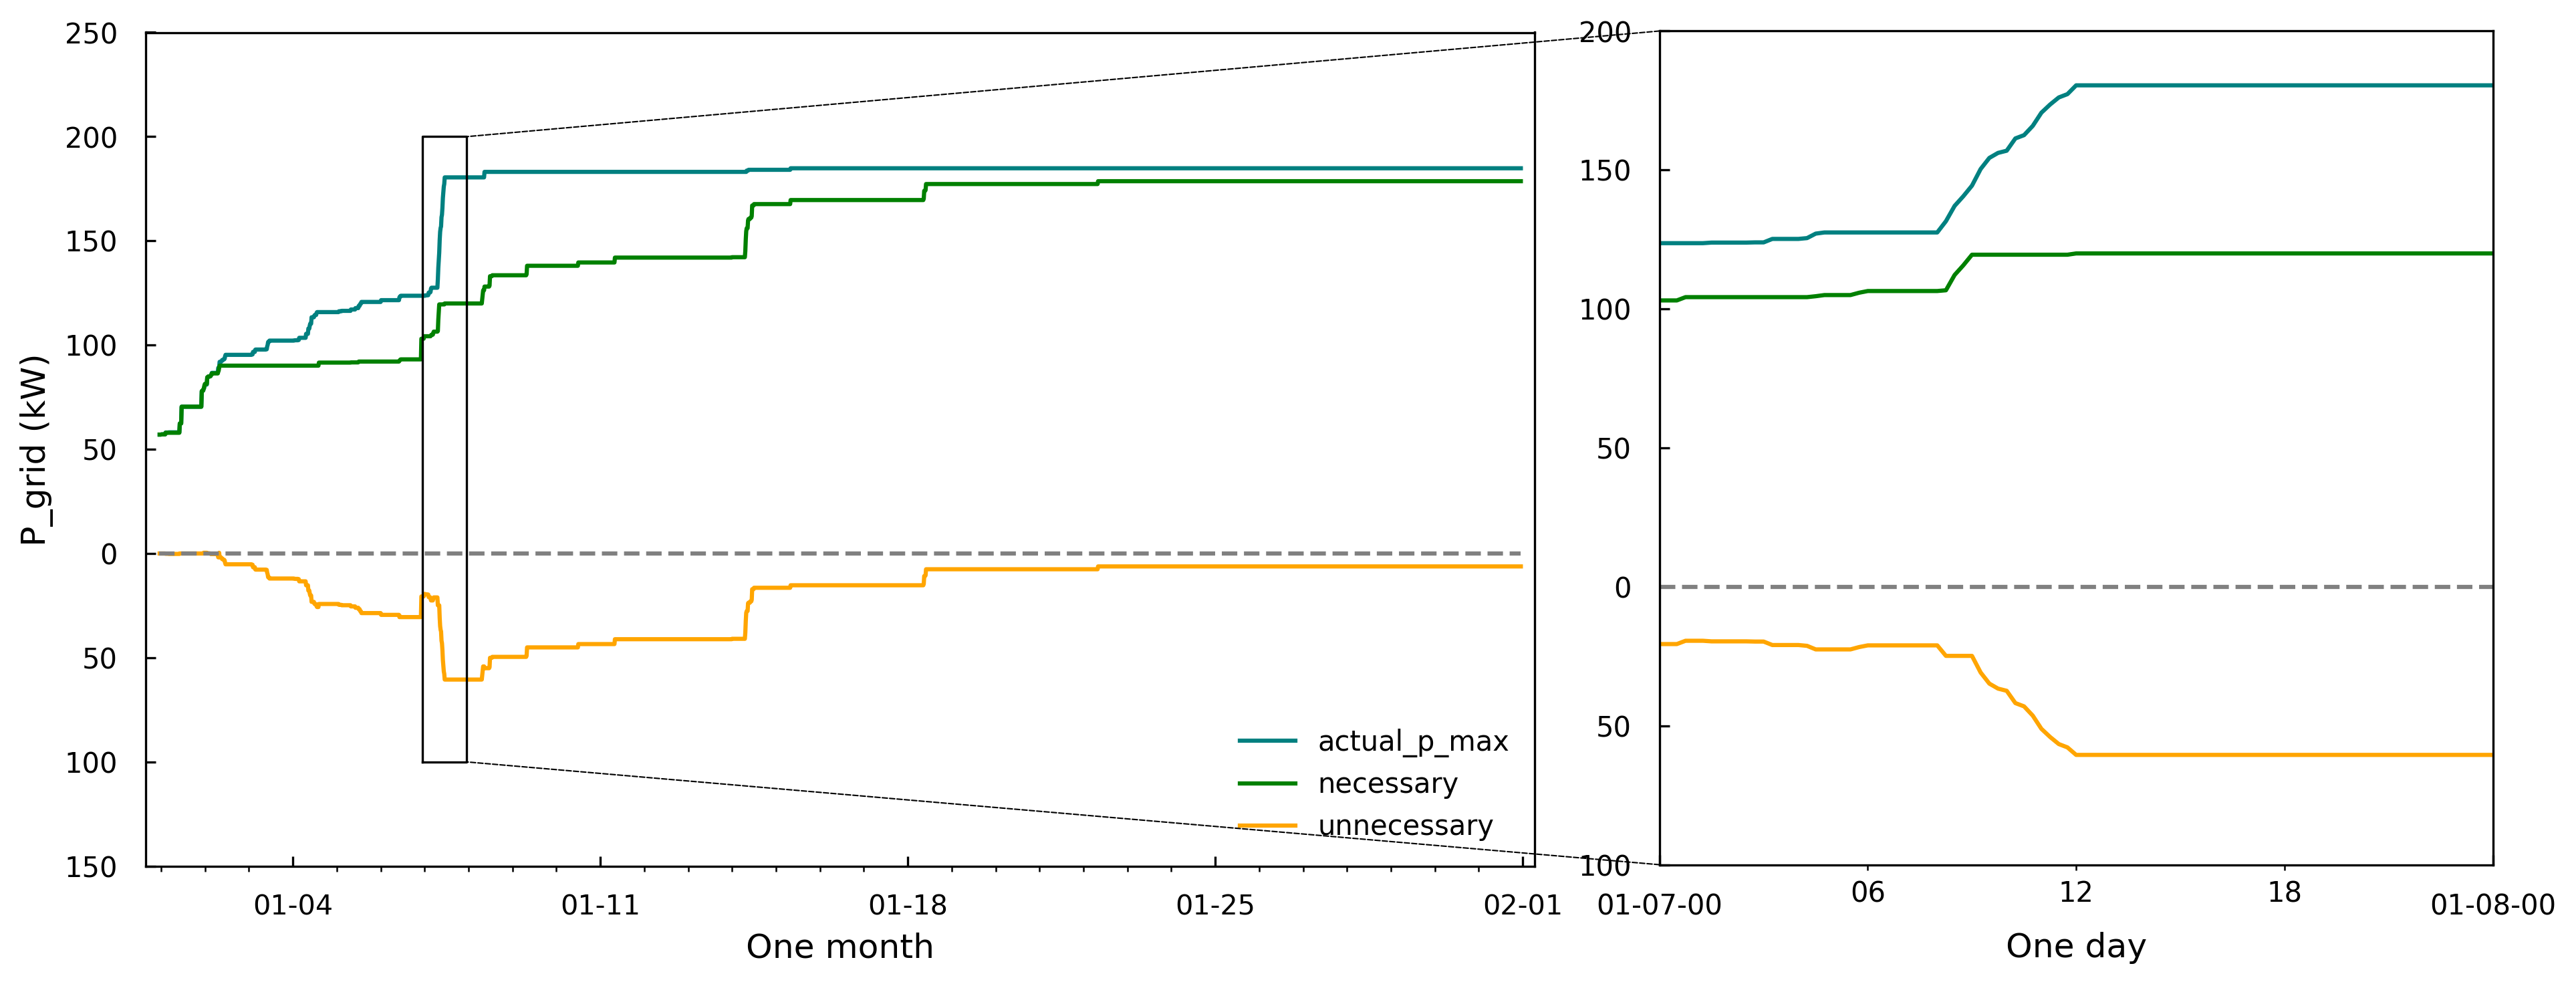

In [4]:
merged_df_Jan=get_merged_df(
    file_folder=r'L:\Coding_project\Energy_grid_new_exp_local\thesis_track_p_grid\6h-bat-Oct-track-p-grid',
    log_fn=r'L:\Coding_project\Energy_grid_new\output\experiments\thesis_track_p_grid\6h-bat-Oct-track-p-grid.xlsx',
    id_exe=1, id_sol=2
)
plot_track_p_max(df_merged=merged_df_Jan,figsize=(8,5),
                 line_keys=['actual_p_max','necessary','unnecessary'],plot_error_bar=False,
                 ylimit_main=[-150,250],ylimit_sub=[-100,200],
                 fontsize=11,
                 inside_start_day=6,inside_days=1,
                 save_fn="track_p_grid_max_Jan.png")

C:\Users\Lunlo\AppData\Local\Temp\ipykernel_6260\3230634387.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=0,fontsize=fontsize*0.9)
C:\Users\Lunlo\AppData\Local\Temp\ipykernel_6260\3230634387.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


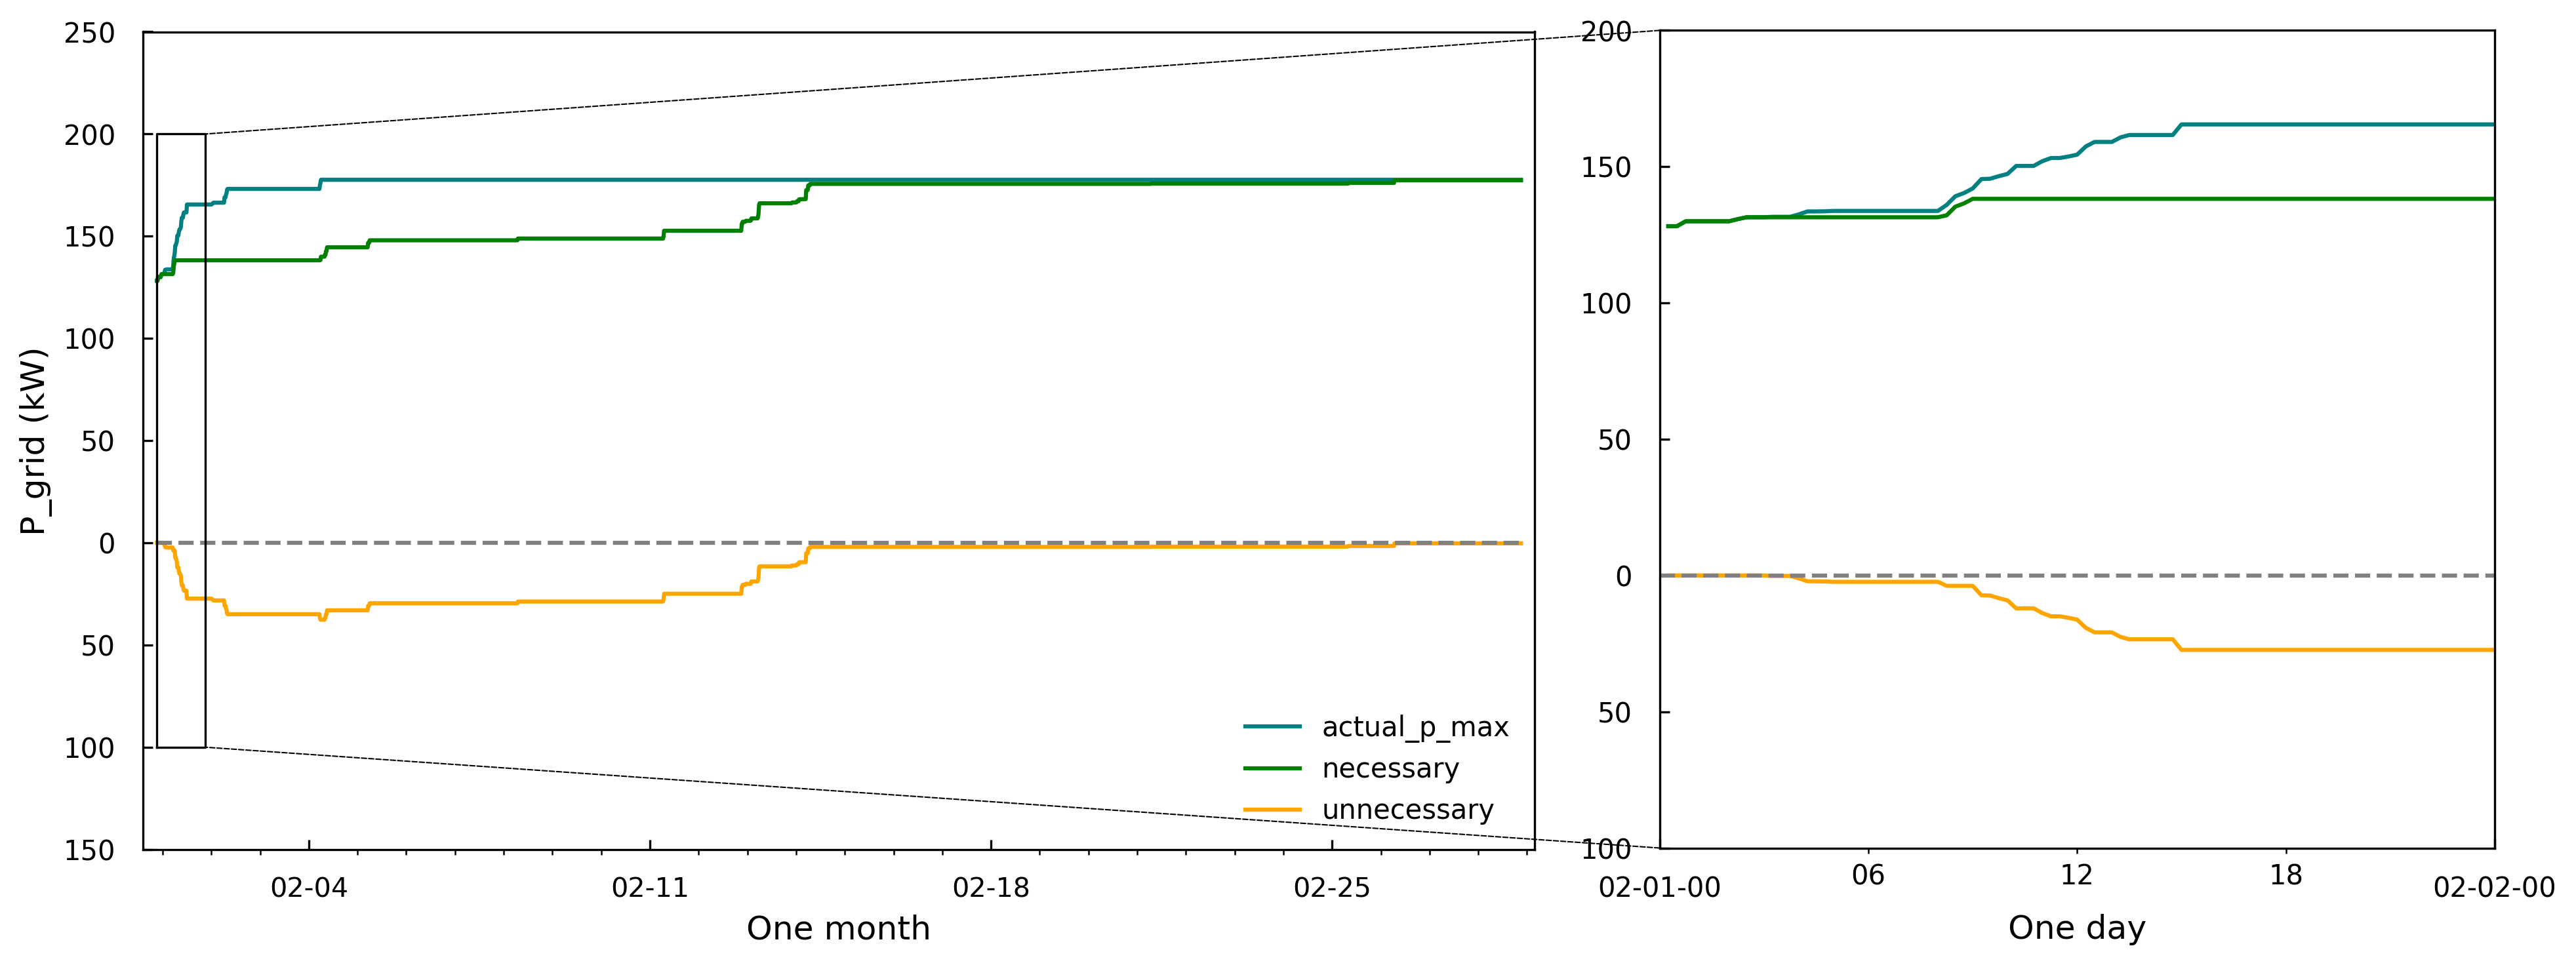

In [5]:
month=2

merged_df_Jan=get_merged_df(
    file_folder=r'L:\Coding_project\Energy_grid_new_exp_local\thesis_track_p_grid\6h-bat-Oct-track-p-grid',
    log_fn=r'L:\Coding_project\Energy_grid_new\output\experiments\thesis_track_p_grid\6h-bat-Oct-track-p-grid.xlsx',
    id_exe=1+3*(month-1), id_sol=2+3*(month-1)
)
plot_track_p_max(df_merged=merged_df_Jan,figsize=(8,5),
                 line_keys=['actual_p_max','necessary','unnecessary'],plot_error_bar=False,
                 ylimit_main=[-150,250],ylimit_sub=[-100,200],
                 fontsize=11,
                 inside_start_day=0,inside_days=1,
                 save_fn="track_p_grid_max_Feb.png")

C:\Users\Lunlo\AppData\Local\Temp\ipykernel_6260\3230634387.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=0,fontsize=fontsize*0.9)
C:\Users\Lunlo\AppData\Local\Temp\ipykernel_6260\3230634387.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


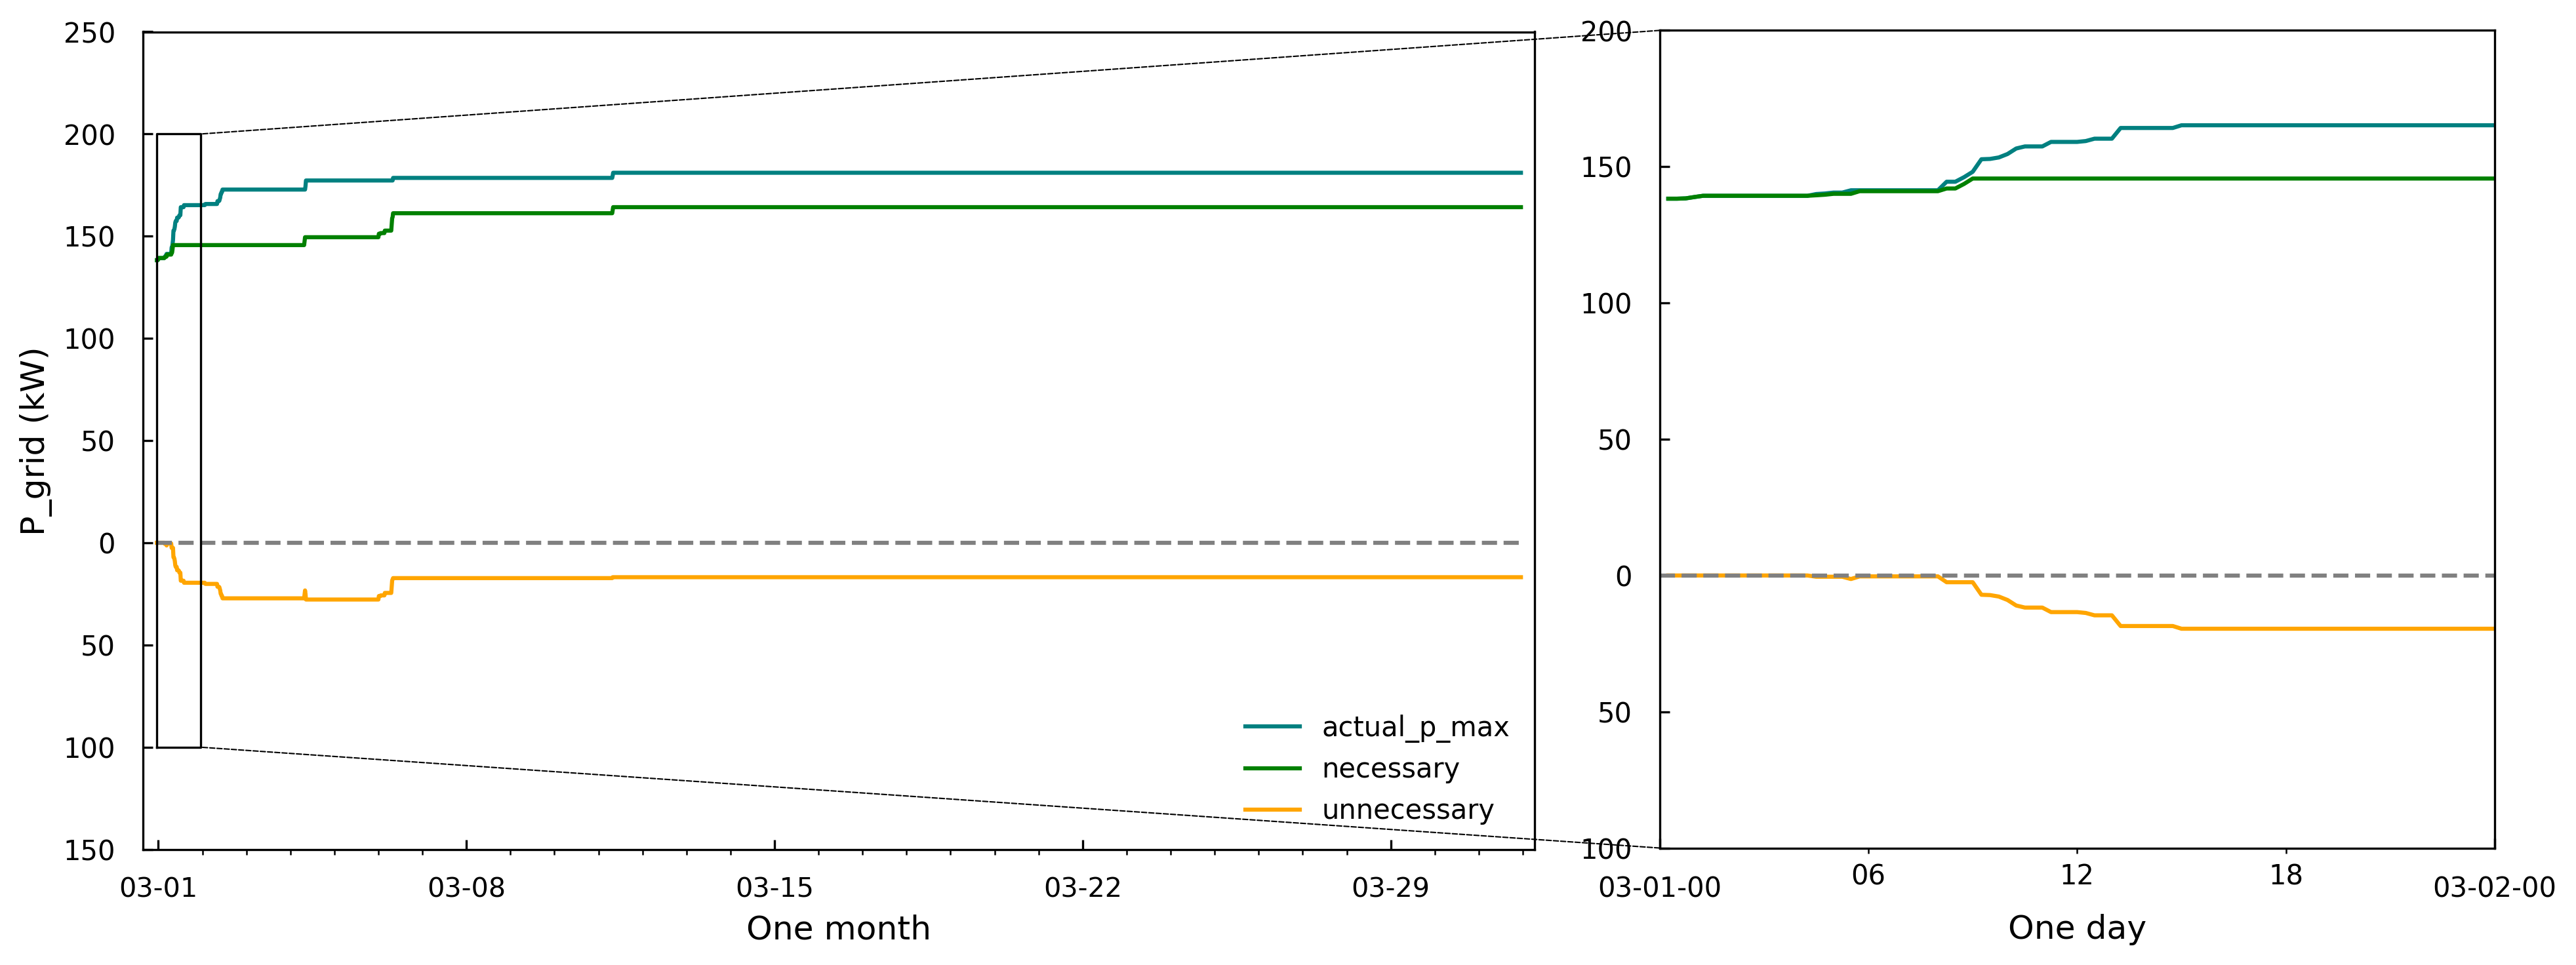

In [6]:
month=3

merged_df_Jan=get_merged_df(
    file_folder=r'L:\Coding_project\Energy_grid_new_exp_local\thesis_track_p_grid\6h-bat-Oct-track-p-grid',
    log_fn=r'L:\Coding_project\Energy_grid_new\output\experiments\thesis_track_p_grid\6h-bat-Oct-track-p-grid.xlsx',
    id_exe=1+3*(month-1), id_sol=2+3*(month-1)
)
plot_track_p_max(df_merged=merged_df_Jan,figsize=(8,5),
                 line_keys=['actual_p_max','necessary','unnecessary'],plot_error_bar=False,
                 ylimit_main=[-150,250],ylimit_sub=[-100,200],
                 fontsize=11,
                 inside_start_day=0,inside_days=1,
                 save_fn="track_p_grid_max_Mar.png")

C:\Users\Lunlo\AppData\Local\Temp\ipykernel_6260\3230634387.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=0,fontsize=fontsize*0.9)
C:\Users\Lunlo\AppData\Local\Temp\ipykernel_6260\3230634387.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


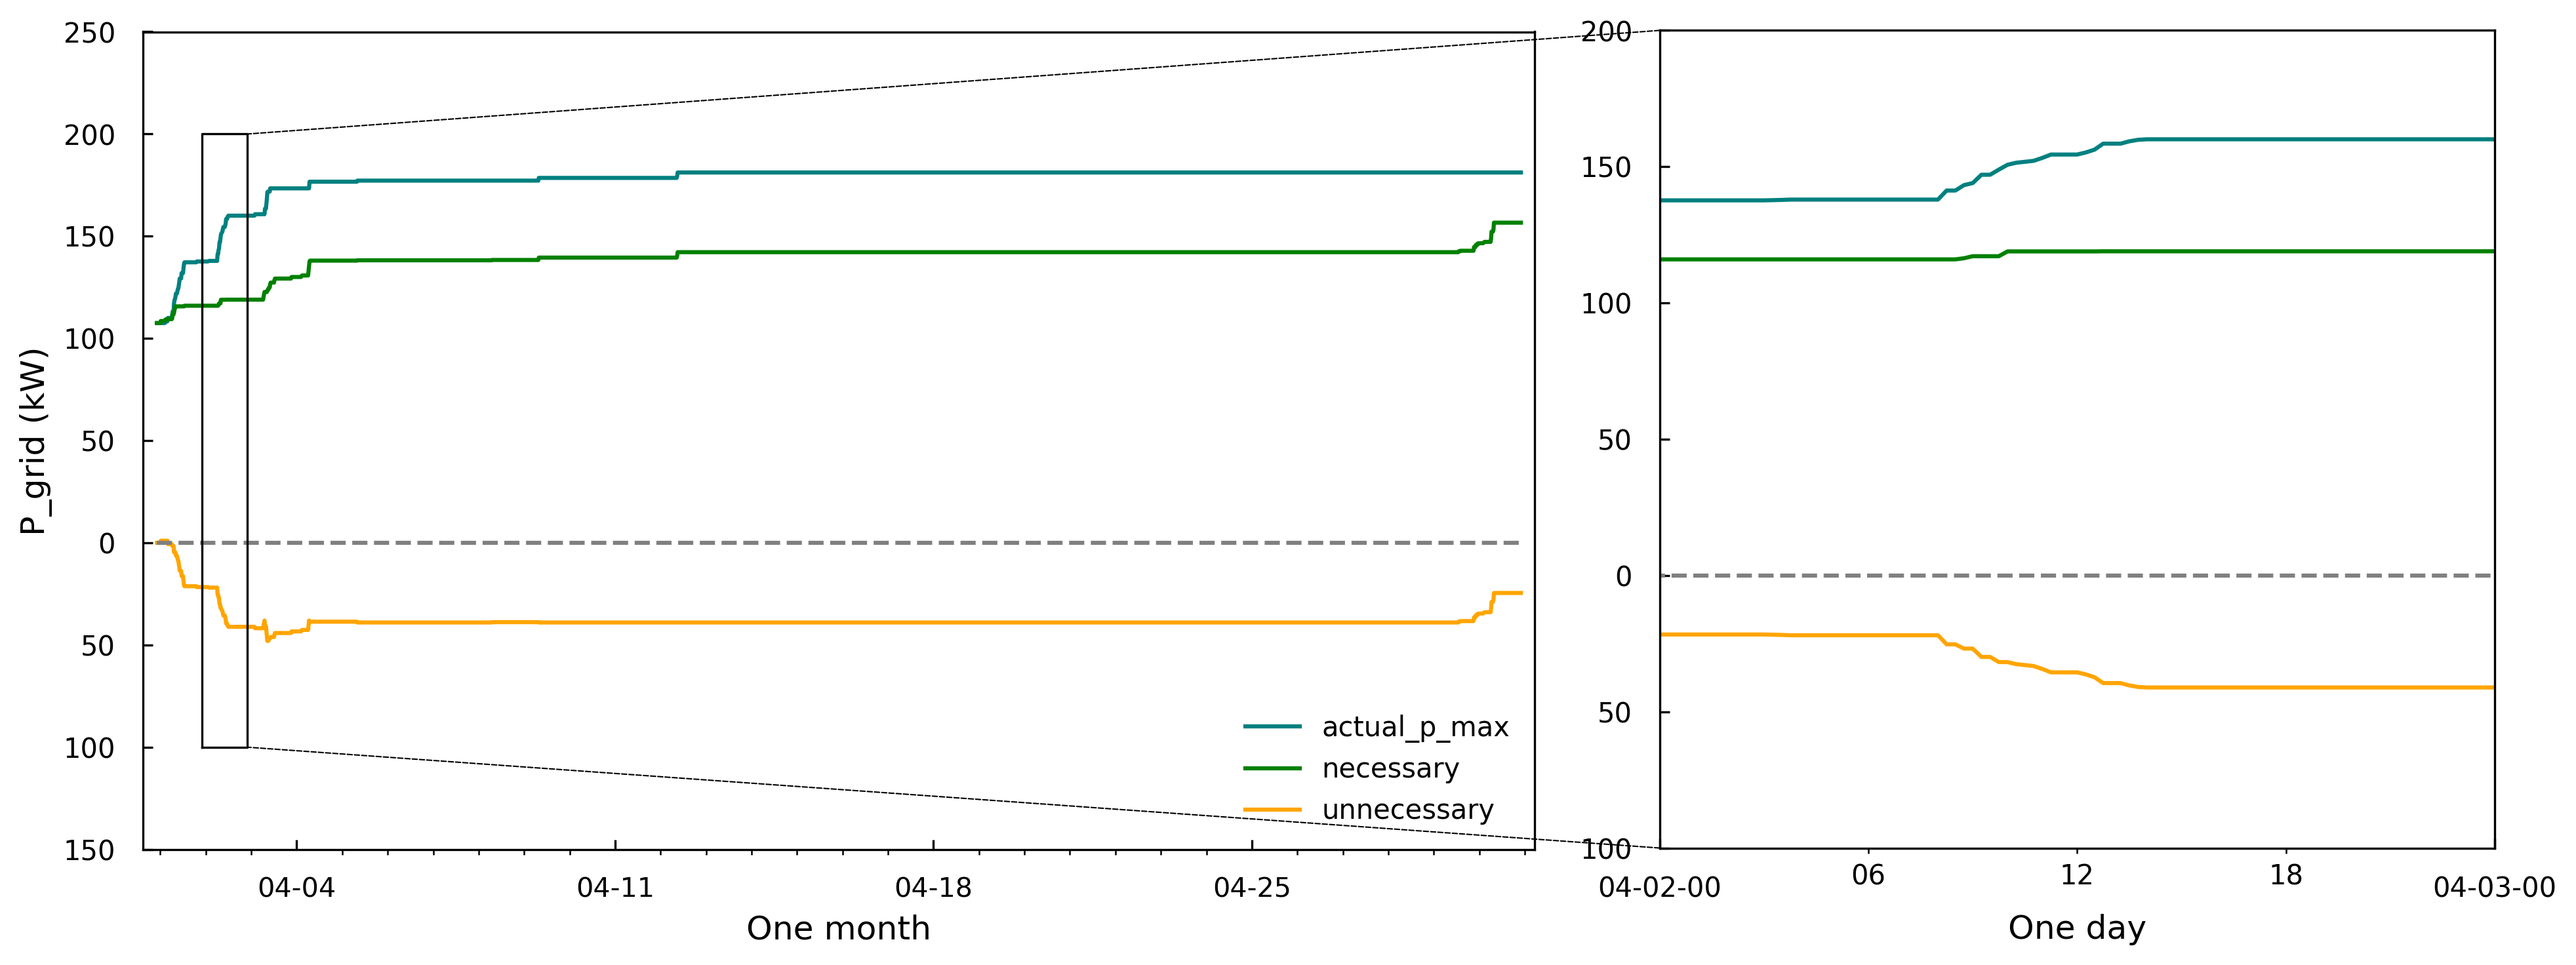

In [7]:
month=4

merged_df_Jan=get_merged_df(
    file_folder=r'L:\Coding_project\Energy_grid_new_exp_local\thesis_track_p_grid\6h-bat-Oct-track-p-grid',
    log_fn=r'L:\Coding_project\Energy_grid_new\output\experiments\thesis_track_p_grid\6h-bat-Oct-track-p-grid.xlsx',
    id_exe=1+3*(month-1), id_sol=2+3*(month-1)
)
plot_track_p_max(df_merged=merged_df_Jan,figsize=(8,5),
                 line_keys=['actual_p_max','necessary','unnecessary'],plot_error_bar=False,
                 ylimit_main=[-150,250],ylimit_sub=[-100,200],
                 fontsize=11,
                 inside_start_day=1,inside_days=1,
                 save_fn="track_p_grid_max_Apr.png")

C:\Users\Lunlo\AppData\Local\Temp\ipykernel_6260\3230634387.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=0,fontsize=fontsize*0.9)
C:\Users\Lunlo\AppData\Local\Temp\ipykernel_6260\3230634387.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


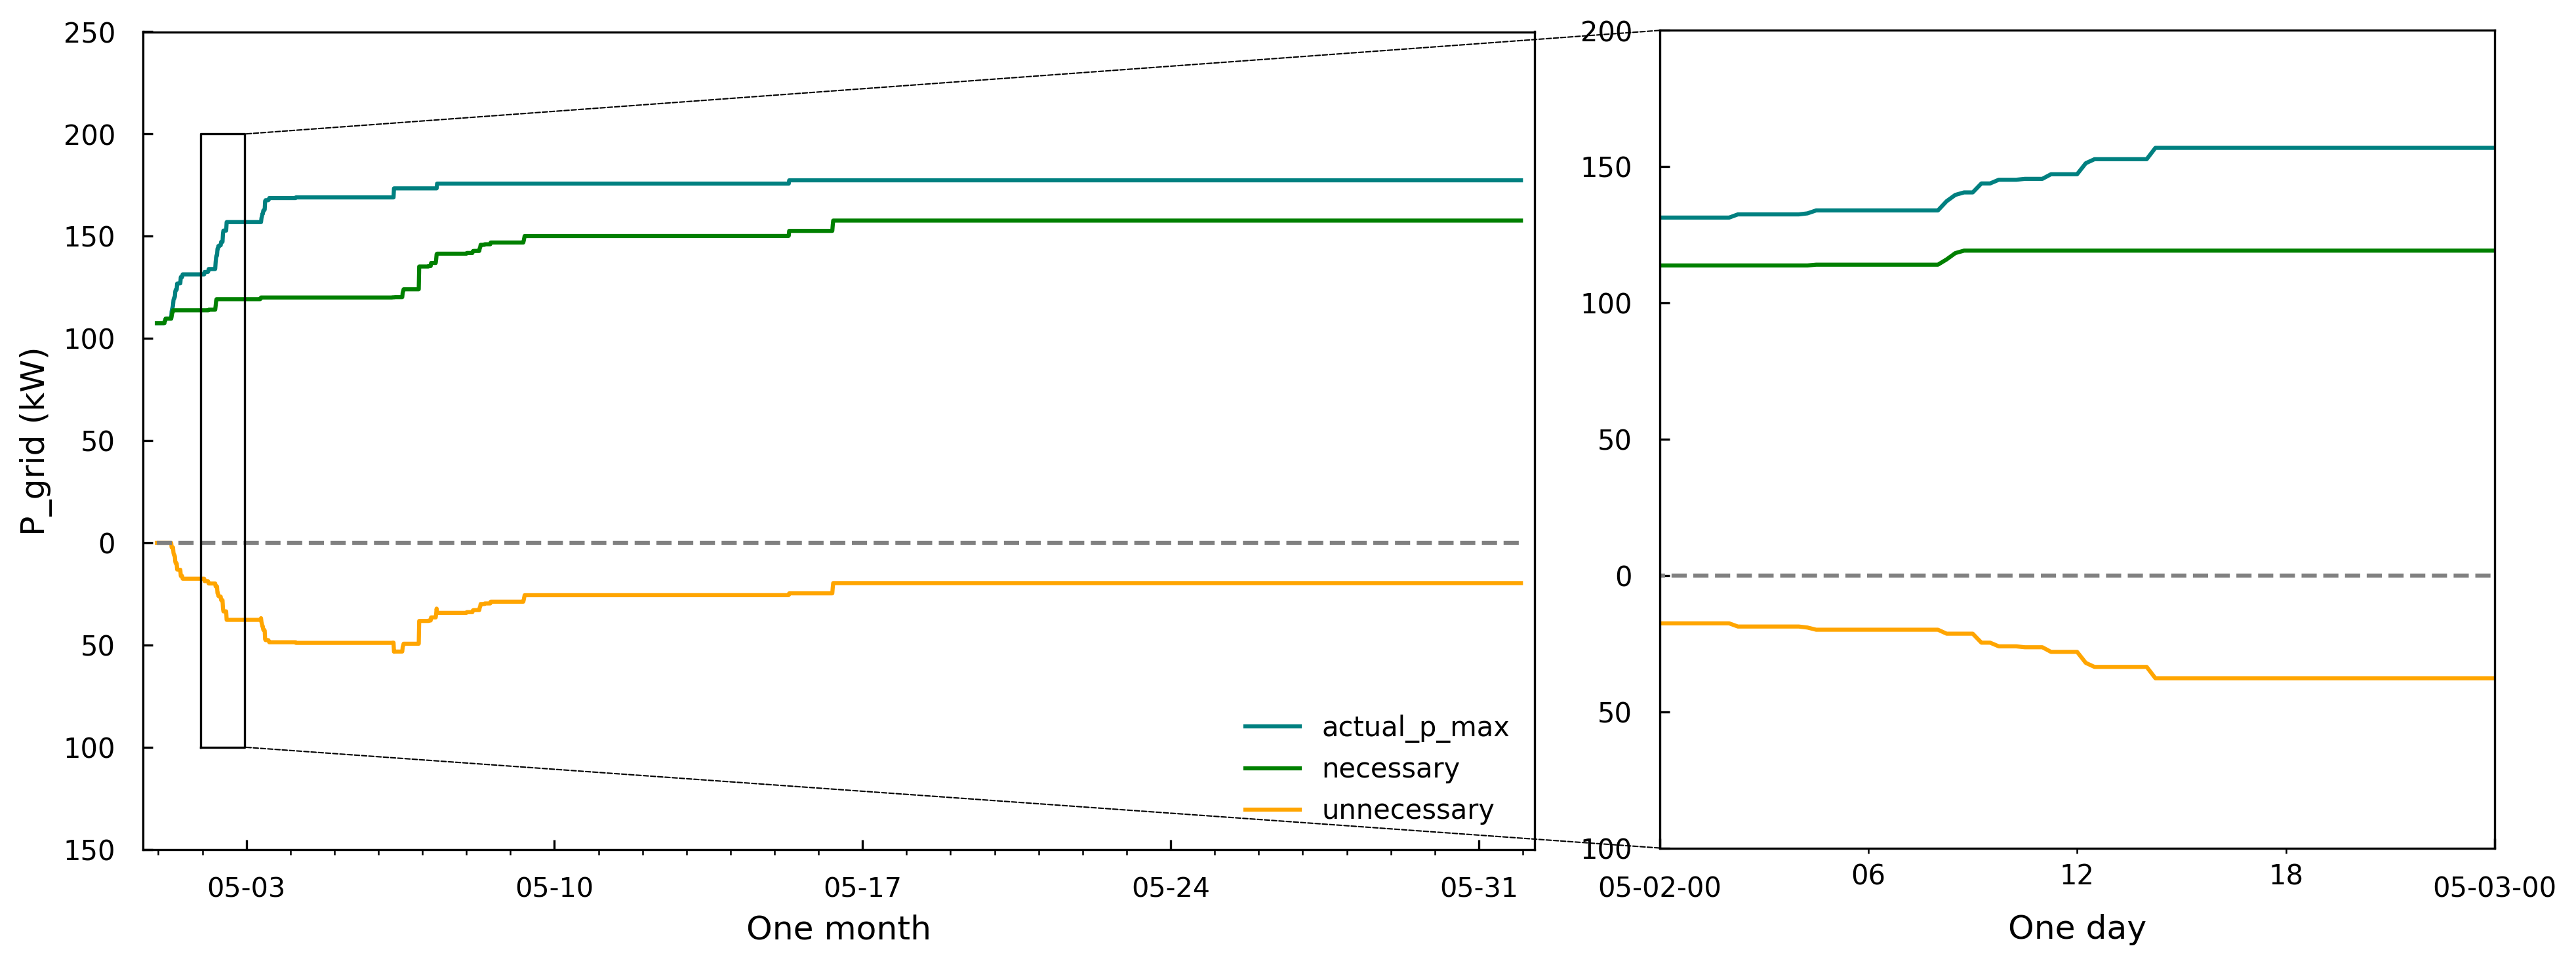

In [8]:
month=5

merged_df_Jan=get_merged_df(
    file_folder=r'L:\Coding_project\Energy_grid_new_exp_local\thesis_track_p_grid\6h-bat-Oct-track-p-grid',
    log_fn=r'L:\Coding_project\Energy_grid_new\output\experiments\thesis_track_p_grid\6h-bat-Oct-track-p-grid.xlsx',
    id_exe=1+3*(month-1), id_sol=2+3*(month-1)
)
plot_track_p_max(df_merged=merged_df_Jan,figsize=(8,5),
                 line_keys=['actual_p_max','necessary','unnecessary'],plot_error_bar=False,
                 ylimit_main=[-150,250],ylimit_sub=[-100,200],
                 fontsize=11,
                 inside_start_day=1,inside_days=1,
                 save_fn="track_p_grid_max_May.png")

C:\Users\Lunlo\AppData\Local\Temp\ipykernel_6260\3230634387.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=0,fontsize=fontsize*0.9)
C:\Users\Lunlo\AppData\Local\Temp\ipykernel_6260\3230634387.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


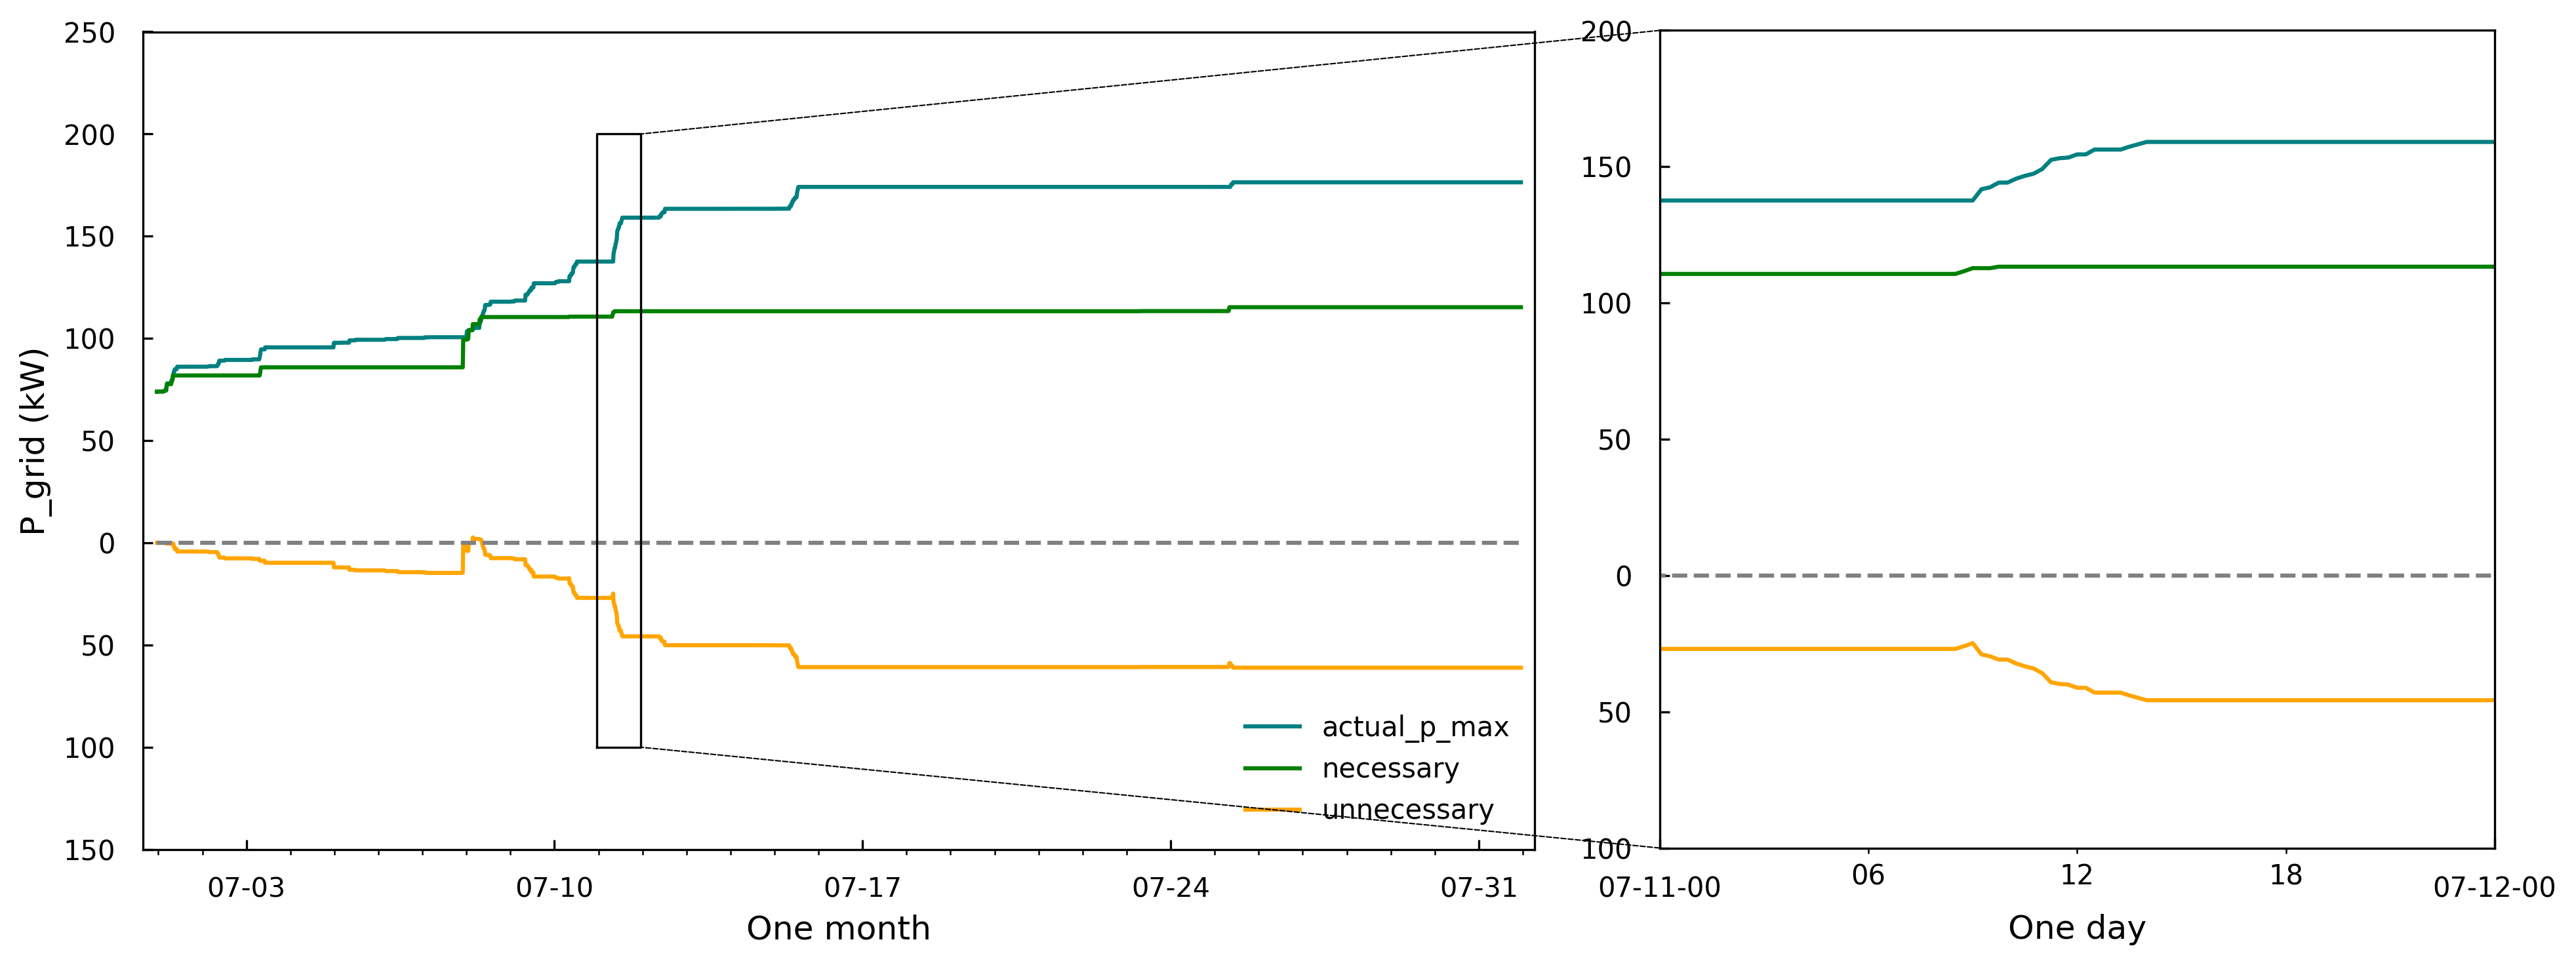

In [11]:
month=7

merged_df_Jan=get_merged_df(
    file_folder=r'L:\Coding_project\Energy_grid_new_exp_local\thesis_track_p_grid\6h-bat-Oct-track-p-grid',
    log_fn=r'L:\Coding_project\Energy_grid_new\output\experiments\thesis_track_p_grid\6h-bat-Oct-track-p-grid.xlsx',
    id_exe=1+3*(month-1), id_sol=2+3*(month-1)
)
plot_track_p_max(df_merged=merged_df_Jan,figsize=(8,5),
                 line_keys=['actual_p_max','necessary','unnecessary'],plot_error_bar=False,
                 ylimit_main=[-150,250],ylimit_sub=[-100,200],
                 fontsize=11,
                 inside_start_day=10,inside_days=1,
                 save_fn="track_p_grid_max_Jul.png")

C:\Users\Lunlo\AppData\Local\Temp\ipykernel_6260\3230634387.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=0,fontsize=fontsize*0.9)
C:\Users\Lunlo\AppData\Local\Temp\ipykernel_6260\3230634387.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


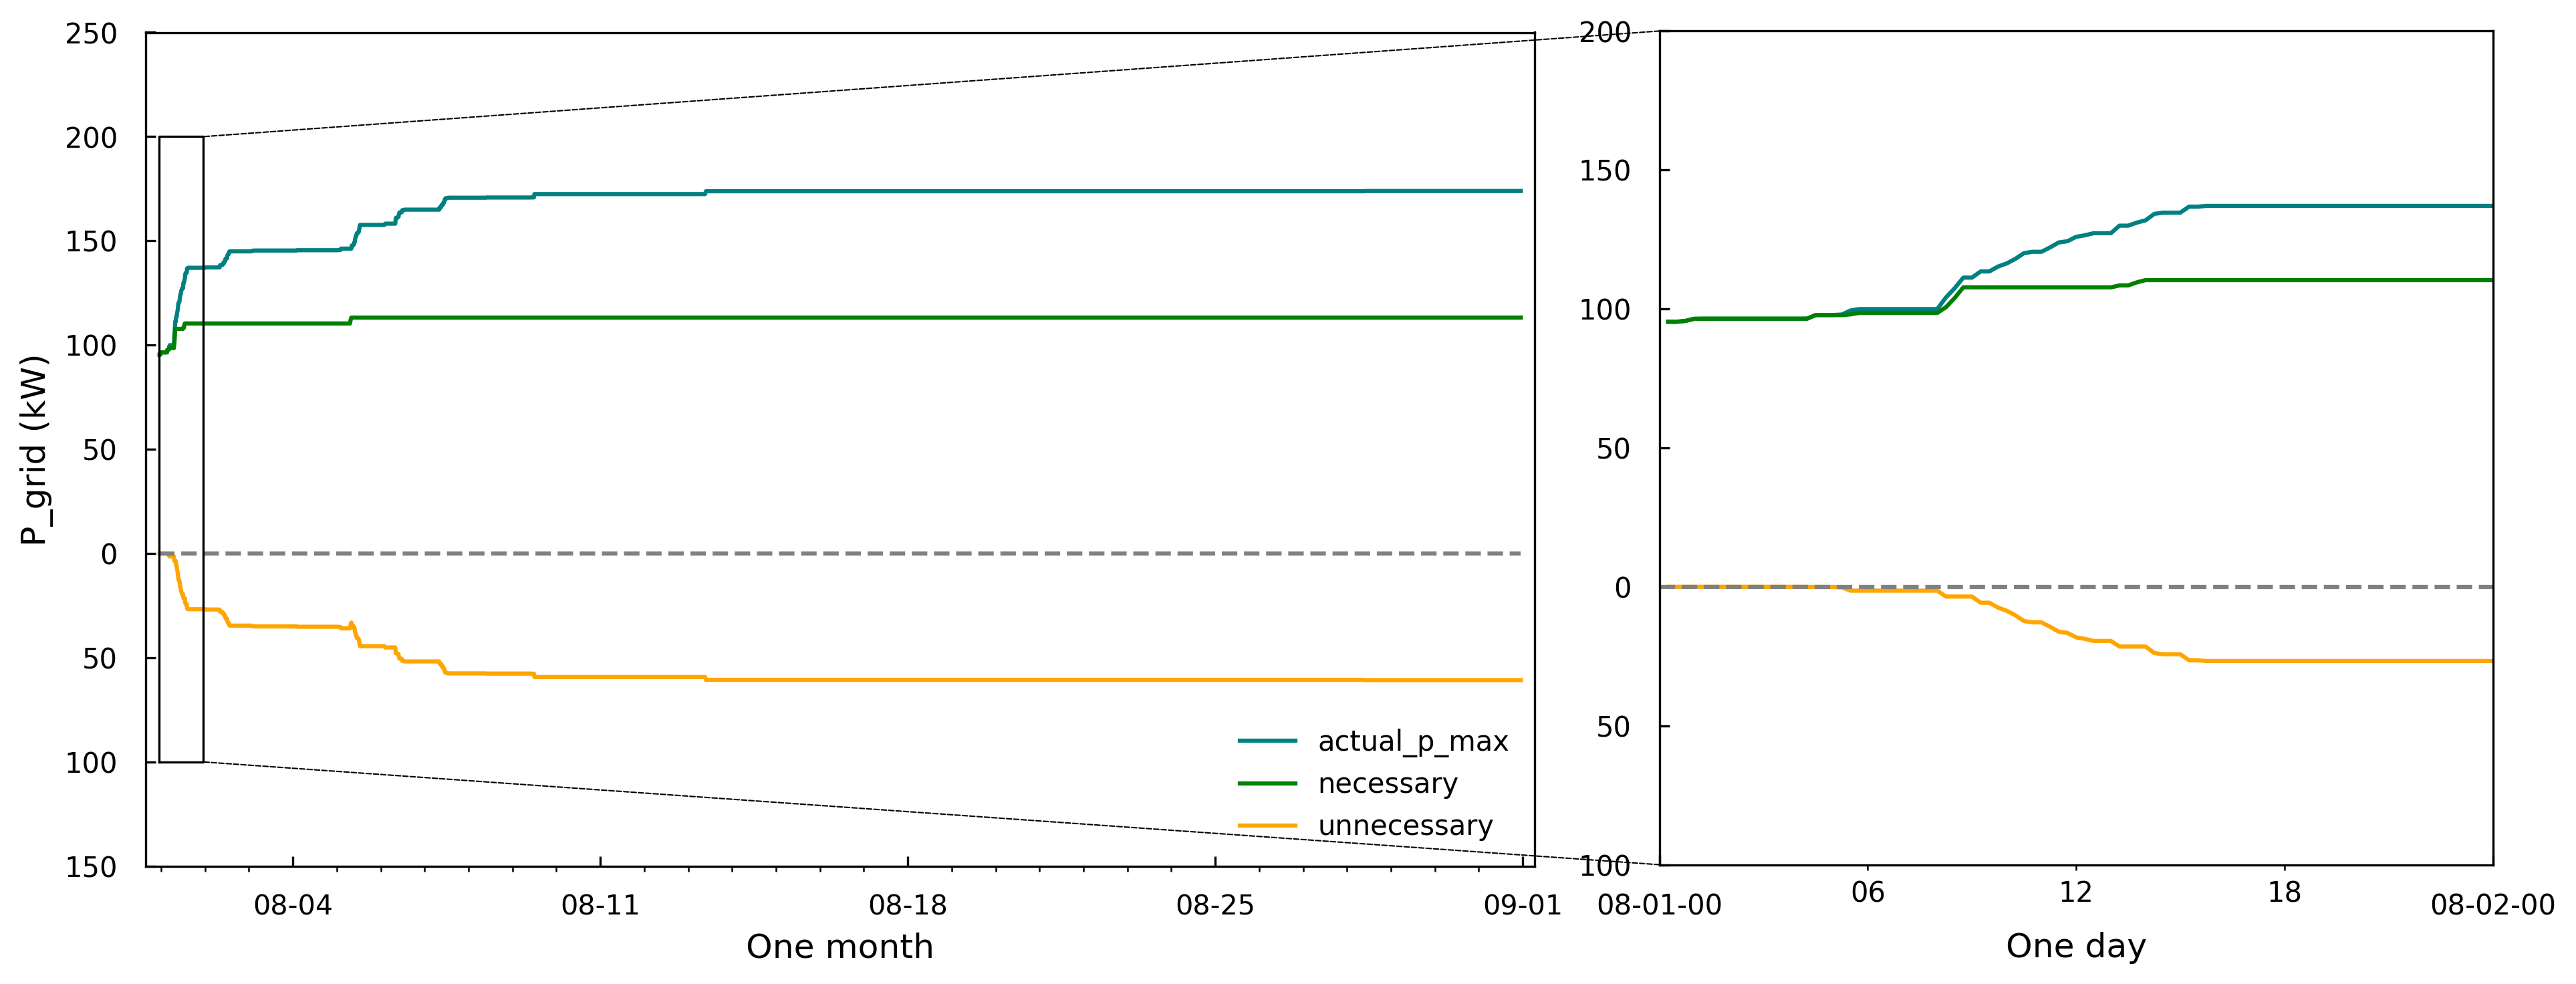

In [12]:
month=8

merged_df_Jan=get_merged_df(
    file_folder=r'L:\Coding_project\Energy_grid_new_exp_local\thesis_track_p_grid\6h-bat-Oct-track-p-grid',
    log_fn=r'L:\Coding_project\Energy_grid_new\output\experiments\thesis_track_p_grid\6h-bat-Oct-track-p-grid.xlsx',
    id_exe=1+3*(month-1), id_sol=2+3*(month-1)
)
plot_track_p_max(df_merged=merged_df_Jan,figsize=(8,5),
                 line_keys=['actual_p_max','necessary','unnecessary'],plot_error_bar=False,
                 ylimit_main=[-150,250],ylimit_sub=[-100,200],
                 fontsize=11,
                 inside_start_day=0,inside_days=1,
                 save_fn="track_p_grid_max_Aug.png")

C:\Users\Lunlo\AppData\Local\Temp\ipykernel_6260\3230634387.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=0,fontsize=fontsize*0.9)
C:\Users\Lunlo\AppData\Local\Temp\ipykernel_6260\3230634387.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


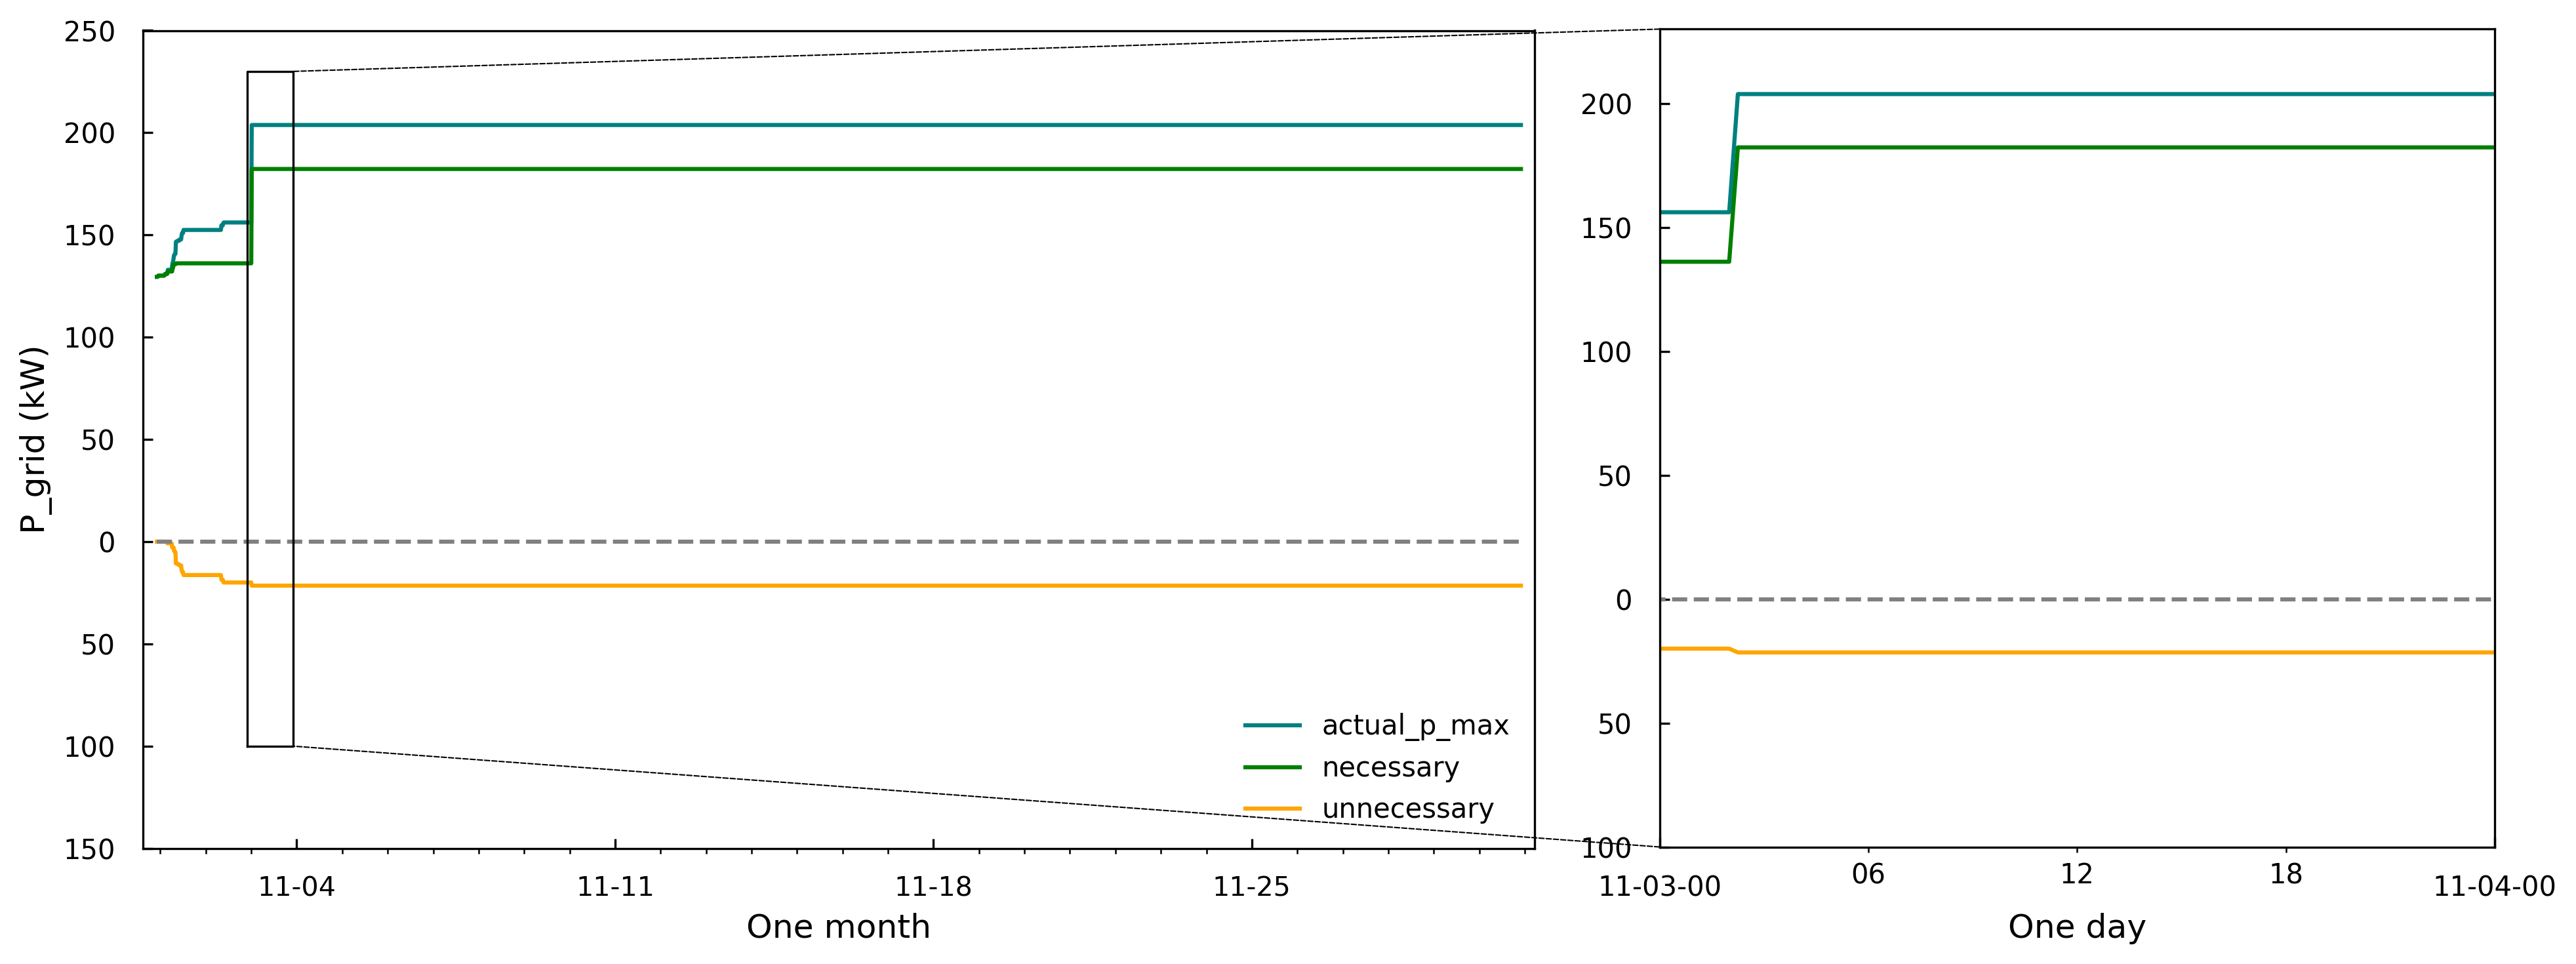

In [13]:
month=11

merged_df_Jan=get_merged_df(
    file_folder=r'L:\Coding_project\Energy_grid_new_exp_local\thesis_track_p_grid\6h-bat-Oct-track-p-grid',
    log_fn=r'L:\Coding_project\Energy_grid_new\output\experiments\thesis_track_p_grid\6h-bat-Oct-track-p-grid.xlsx',
    id_exe=1+3*(month-1), id_sol=2+3*(month-1)
)
plot_track_p_max(df_merged=merged_df_Jan,figsize=(8,5),
                 line_keys=['actual_p_max','necessary','unnecessary'],plot_error_bar=False,
                 ylimit_main=[-150,250],ylimit_sub=[-100,230],
                 fontsize=11,
                 inside_start_day=2,inside_days=1,
                 save_fn="track_p_grid_max_Dec.png")

C:\Users\Lunlo\AppData\Local\Temp\ipykernel_6260\3230634387.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=0,fontsize=fontsize*0.9)
C:\Users\Lunlo\AppData\Local\Temp\ipykernel_6260\3230634387.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


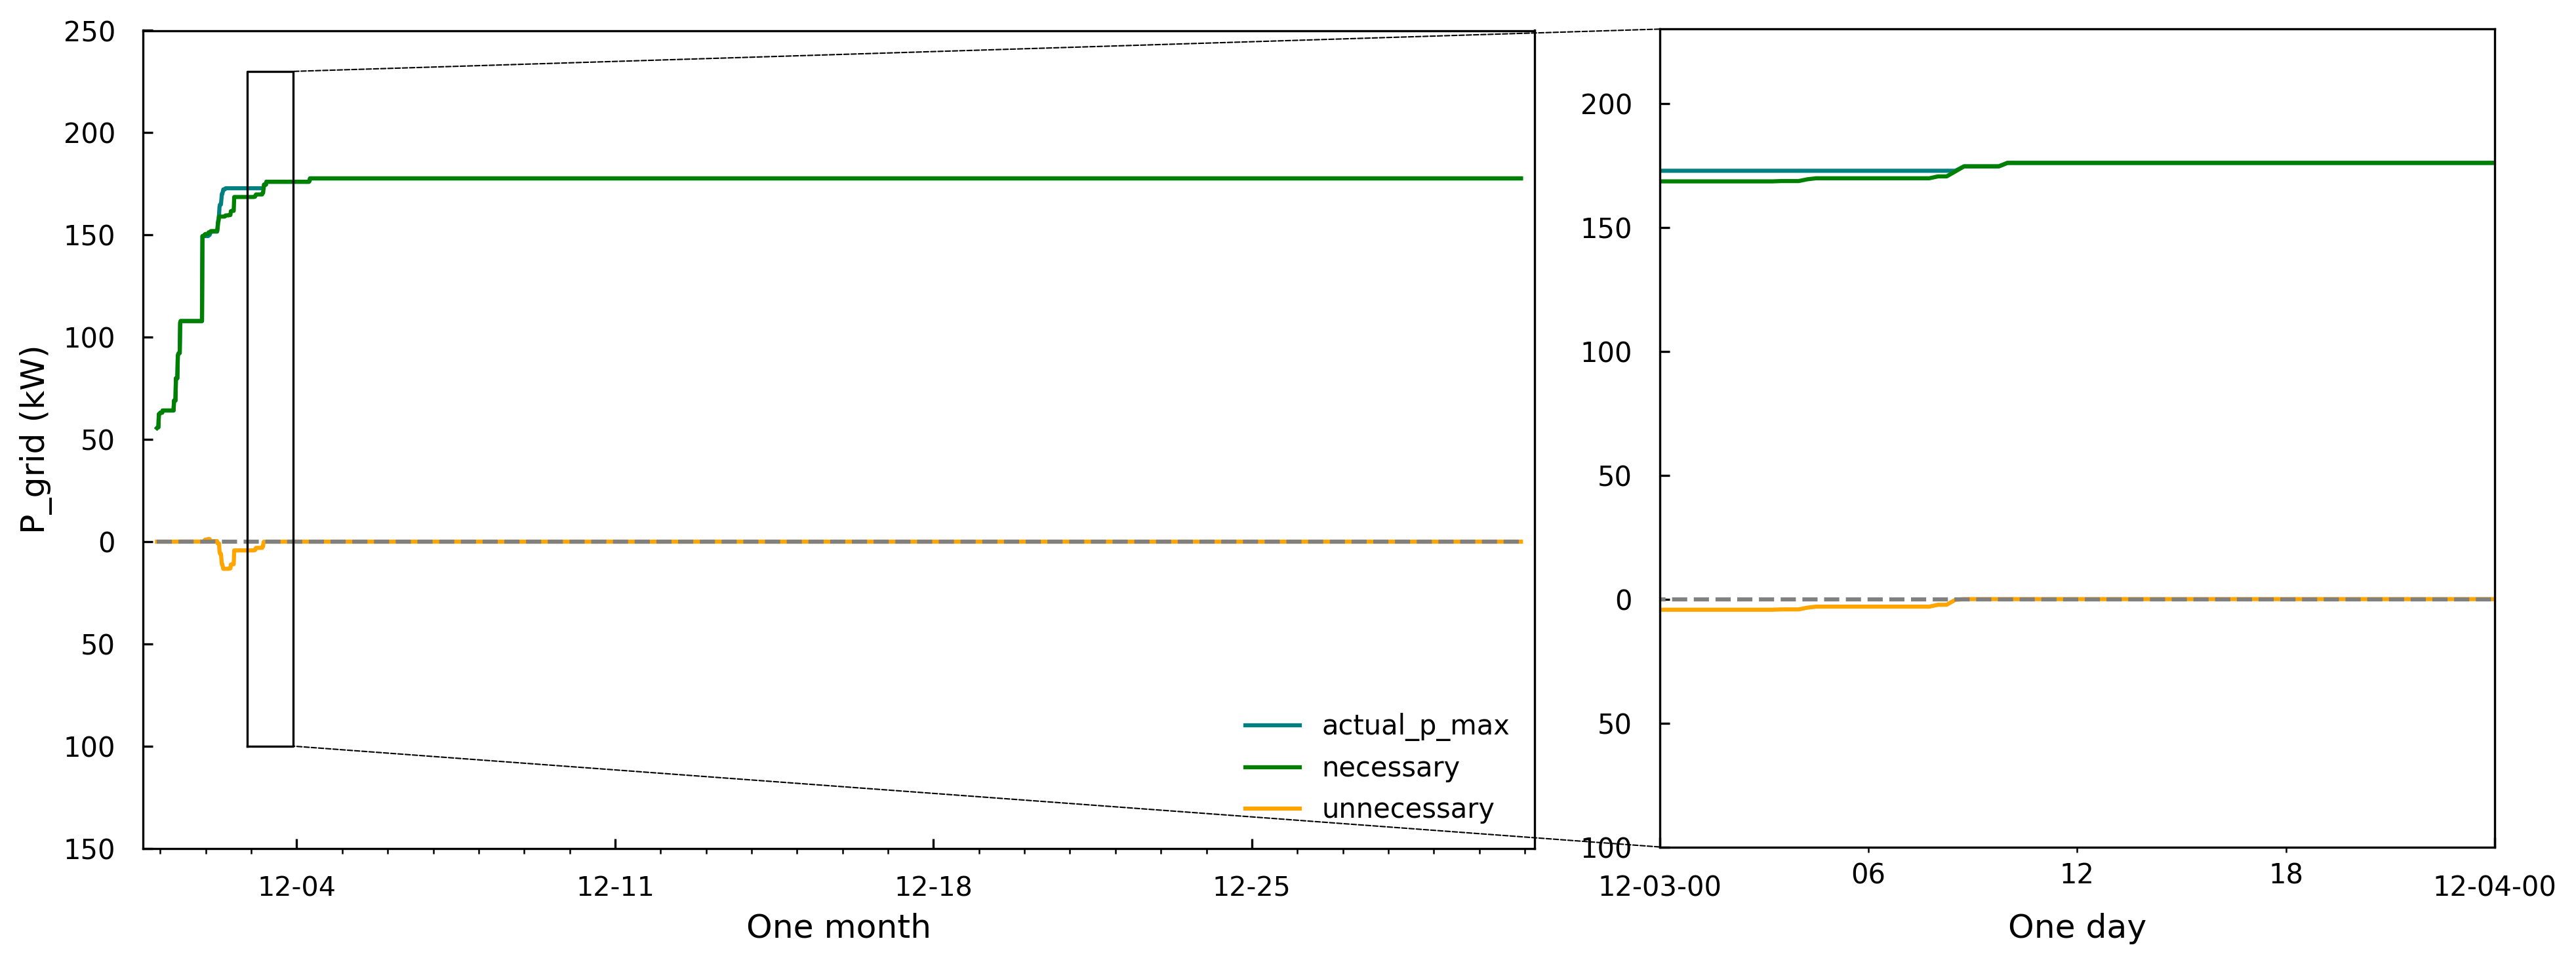

In [14]:
month=12

merged_df_Jan=get_merged_df(
    file_folder=r'L:\Coding_project\Energy_grid_new_exp_local\thesis_track_p_grid\6h-bat-Oct-track-p-grid',
    log_fn=r'L:\Coding_project\Energy_grid_new\output\experiments\thesis_track_p_grid\6h-bat-Oct-track-p-grid.xlsx',
    id_exe=1+3*(month-1), id_sol=2+3*(month-1)
)
plot_track_p_max(df_merged=merged_df_Jan,figsize=(8,5),
                 line_keys=['actual_p_max','necessary','unnecessary'],plot_error_bar=False,
                 ylimit_main=[-150,250],ylimit_sub=[-100,230],
                 fontsize=11,
                 inside_start_day=2,inside_days=1,
                 save_fn="track_p_grid_max_Nov.png")